# Model-free Analysis

The grid search resulted in diverging log likelihoods. Assuming that the loss calculation is correct, a sanity check must be conducted on generated data to demonstrate that it makes empirical conditions.

#### $P(firstFixation\;on\;best|relative\;value\;difference)$

In [1]:
import pandas as pd
import numpy as np
import ast

# Load your CSV
df = pd.read_csv('/Users/braydenchien/Desktop/Enkavilab/DDM/simulated_data/sim_trials_42_0.75_0.38_0.35.csv')

# Convert fixation string to list
df['fixation'] = df['fixation'].apply(ast.literal_eval)

# Compute relative value difference
df['difficulty_raw'] = df['avgWTP_left'] - df['avgWTP_right']
df['difficulty_abs'] = np.abs(df['difficulty_raw'])
df['left_larger'] = df['difficulty_raw'] >= 0

In [2]:
bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
labels = [0,1,2,3,4]
df['difficulty'] = pd.cut(df['difficulty_abs'], bins=bins, labels=labels).astype(float)

In [3]:
def first_fix_best(row):
    fix = row['fixation']
    i = 0
    while i < len(fix) and fix[i]==0:
        i +=1
    if i==len(fix):
        return np.nan  # No fixation
    if (fix[i]==1 and row['left_larger']) or (fix[i]==2 and not row['left_larger']):
        return 1
    else:
        return 0

df['firstFixBest'] = df.apply(first_fix_best, axis=1)

In [4]:
def std_error(x):
    return x.std(ddof=1)/np.sqrt(x.count())

summary = df.groupby('difficulty', observed=True).agg(
    y_mean = ('firstFixBest','mean'),
    y_se = ('firstFixBest', std_error)
).reset_index()

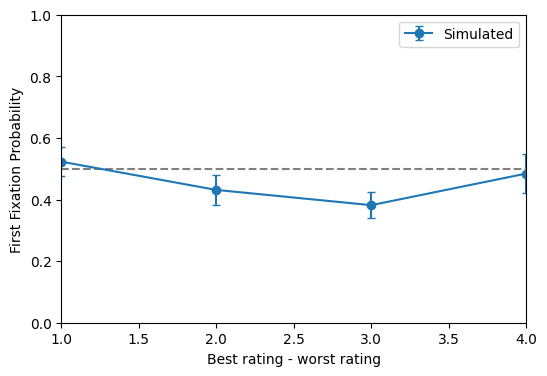

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))

# Exclude difficulty==0 (as in R)
summary_plot = summary.loc[summary['difficulty'] != 0]

ax.errorbar(
    summary_plot['difficulty'],
    summary_plot['y_mean'],
    yerr=summary_plot['y_se'],
    fmt='o-',
    capsize=3,
    label="Simulated"
)

ax.axhline(0.5, color='grey', linestyle='--')
ax.set_xlabel("Best rating - worst rating")
ax.set_ylabel("First Fixation Probability")
ax.set_xlim(1,4)
ax.set_ylim(0,1)
ax.legend()
plt.show()

## Fixation duration by fixation type

In [6]:
import pandas as pd
import numpy as np
import ast

df = pd.read_csv('/Users/braydenchien/Desktop/Enkavilab/DDM/simulated_data/sim_trials_42_0.75_0.38_0.35.csv')
df['fixation'] = df['fixation'].apply(ast.literal_eval)

In [7]:
keys = ['first', 'middle', 'last']
fix_dicts = {k: [] for k in keys}

for trial in df.itertuples():
    sequence = trial.fixation

    # Skip latency (leading 0s)
    i = 0
    while i < len(sequence) and sequence[i] == 0:
        i += 1

    # If only 0s, skip trial
    if i == len(sequence):
        continue

    fixation_lengths = []

    # Iterate through fixations
    while i < len(sequence):
        # Skip any 0s between fixations
        while i < len(sequence) and sequence[i] == 0:
            i += 1
        if i == len(sequence):
            break

        start_index = i
        current_fix = sequence[start_index]

        while i < len(sequence) and sequence[i] == current_fix:
            i += 1

        end_index = i
        fixation_lengths.append(end_index - start_index)

    # Categorize into first/middle/last
    if len(fixation_lengths) == 1:
        fix_dicts['first'].append(fixation_lengths[0])
    else:
        fix_dicts['first'].append(fixation_lengths[0])
        fix_dicts['last'].append(fixation_lengths[-1])
        for middle_fix in fixation_lengths[1:-1]:
            fix_dicts['middle'].append(middle_fix)

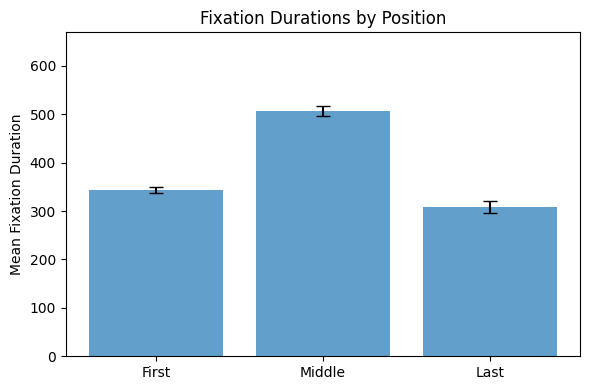

In [8]:
import numpy as np

# Example data (replace these with your actual computed lists)
# fix_dicts = {'first': [...], 'middle': [...], 'last': [...]}

# Compute means and standard errors
def std_error(x):
    arr = np.array(x)
    return arr.std(ddof=1) / np.sqrt(len(arr))

means = [
    np.mean(fix_dicts['first']),
    np.mean(fix_dicts['middle']),
    np.mean(fix_dicts['last'])
]

errors = [
    std_error(fix_dicts['first']),
    std_error(fix_dicts['middle']),
    std_error(fix_dicts['last'])
]

labels = ['First', 'Middle', 'Last']

# Create bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, means, yerr=errors, capsize=5, alpha=0.7)

plt.ylabel('Mean Fixation Duration')
plt.title('Fixation Durations by Position')
plt.ylim(0, max(means) + max(errors) + 150)

plt.tight_layout()
plt.show()


## Middle fixation duration by relative value difference

In [9]:
import pandas as pd
import numpy as np
import ast

df = pd.read_csv('/Users/braydenchien/Desktop/Enkavilab/DDM/simulated_data/sim_trials_42_0.75_0.38_0.35.csv')
df['fixation'] = df['fixation'].apply(ast.literal_eval)

In [10]:
middle_fixations = []  # Each entry will be (fixation_length, rating)

for trial in df.itertuples():
    sequence = trial.fixation
    rating = abs(trial.avgWTP_left - trial.avgWTP_right)

    # Skip leading zeros (latency)
    i = 0
    while i < len(sequence) and sequence[i] == 0:
        i += 1
    if i == len(sequence):
        continue  # Only zeros — skip trial

    fixations = []  # Will store (start_index, end_index) tuples

    # Identify contiguous fixation chunks
    while i < len(sequence):
        while i < len(sequence) and sequence[i] == 0:
            i += 1
        if i == len(sequence):
            break

        start = i
        current_id = sequence[i]

        while i < len(sequence) and sequence[i] == current_id:
            i += 1
        end = i

        fixations.append((start, end))  # store as index range

    # Only process middle fixations (skip first and last)
    if len(fixations) > 2:
        for start, end in fixations[1:-1]:
            fixation_length = end - start
            middle_fixations.append((fixation_length, rating))

319
137
66
48
9


/var/folders/59/03h51wmn6xn1jhvb7kj9fjc40000gn/T/ipykernel_15706/1667943614.py:42: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


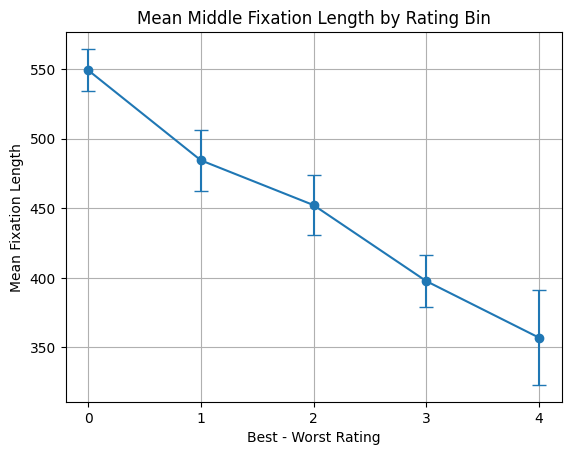

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# Sample data: list of (fixation_length, rating) tuples
data = middle_fixations

# Define rating bins
rating_bins = [0, 1, 2, 3, 4, 5]  # edges of bins

# Convert to numpy arrays
numbers = np.array([x[0] for x in data])
ratings = np.array([x[1] for x in data])

# Prepare data for plotting
x_positions = []  # 0, 1, 2, ...
means = []
errors = []

# Loop through each bin
for i in range(len(rating_bins) - 1):
    bin_start = rating_bins[i]
    bin_end = rating_bins[i + 1]

    mask = (ratings >= bin_start) & (ratings < bin_end)
    bin_data = numbers[mask]
    print(f'{len(bin_data)}')

    x_positions.append(i)  # always include the bin

    if len(bin_data) > 0:
        mean = np.mean(bin_data)
        sem = scipy.stats.sem(bin_data, ddof=1)
    else:
        mean = 0
        sem = 0

    means.append(mean)
    errors.append(sem)

# Plotting
plt.errorbar(
    x_positions, means, yerr=errors,
    fmt='o', capsize=5, linestyle='-', marker='o'
)
plt.xlabel('Best - Worst Rating')
plt.ylabel('Mean Fixation Length')
plt.title('Mean Middle Fixation Length by Rating Bin')
plt.xticks(
    ticks=x_positions,
    labels=[f'{rating_bins[i]}' for i in x_positions]
)
plt.grid(True)
plt.show()

## First fixation duration by relative value difference

In [12]:
import pandas as pd
import numpy as np
import ast

# Load and parse the fixation sequences
df = pd.read_csv('/Users/braydenchien/Desktop/Enkavilab/DDM/simulated_data/sim_trials_42_0.75_0.38_0.35.csv')
df['fixation'] = df['fixation'].apply(ast.literal_eval)

In [13]:
first_fixations = []  # Each entry will be (fixation_length, rating)

for trial in df.itertuples():
    sequence = trial.fixation
    rating = abs(trial.avgWTP_left - trial.avgWTP_right)

    # Skip leading zeros (latency)
    i = 0
    while i < len(sequence) and sequence[i] == 0:
        i += 1
    if i == len(sequence):
        continue  # Only zeros — skip trial

    fixations = []  # Store (start_index, end_index) tuples

    # Identify contiguous fixation chunks
    while i < len(sequence):
        while i < len(sequence) and sequence[i] == 0:
            i += 1
        if i == len(sequence):
            break

        start = i
        current_id = sequence[i]
        while i < len(sequence) and sequence[i] == current_id:
            i += 1
        end = i

        fixations.append((start, end))

    # Process only the first fixation (if one exists)
    if len(fixations) >= 2:
        start, end = fixations[0]
        fixation_length = end - start
        first_fixations.append((fixation_length, rating))

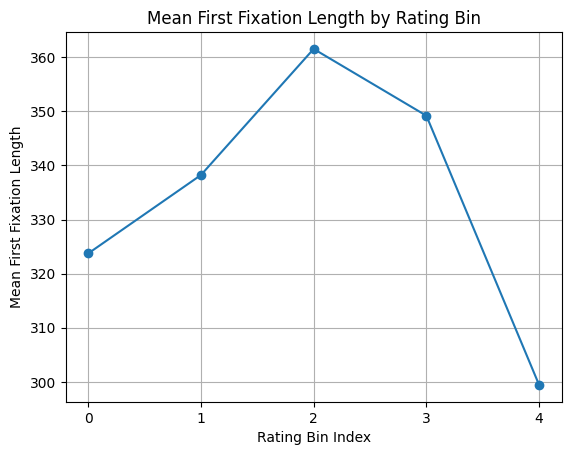

In [14]:
import matplotlib.pyplot as plt
import scipy.stats

# Define rating bins
rating_bins = [0, 1, 2, 3, 4, 5]  # edges of bins

# Convert to numpy arrays
numbers = np.array([x[0] for x in first_fixations])
ratings = np.array([x[1] for x in first_fixations])

# Prepare data for plotting
x_positions = []  # 0, 1, 2, ...
means = []

# Loop through each bin
for i in range(len(rating_bins) - 1):
    bin_start = rating_bins[i]
    bin_end = rating_bins[i + 1]

    mask = (ratings >= bin_start) & (ratings < bin_end)
    bin_data = numbers[mask]

    x_positions.append(i)  # always include the bin

    if len(bin_data) > 0:
        mean = np.mean(bin_data)
    else:
        mean = 0

    means.append(mean)

# Plotting
plt.xlabel('Rating Bin Index')
plt.ylabel('Mean First Fixation Length')
plt.title('Mean First Fixation Length by Rating Bin')
plt.xticks(
    ticks=x_positions,
    labels=[f'{rating_bins[i]}' for i in x_positions]
)
plt.plot(x_positions, means, marker='o')
plt.grid(True)
plt.show()

## Net fixation duration by relative value difference

In [21]:
import pandas as pd
import numpy as np
import ast

df = pd.read_csv('/Users/braydenchien/Desktop/Enkavilab/DDM/simulated_data/sim_trials_42_0.75_0.38_0.35.csv')
df['fixation'] = df['fixation'].apply(ast.literal_eval)

In [22]:
all_fixations = []  # List of (net_fixation_length, rdv)

for trial in df.itertuples():
    # i = 0
    # while i < len(sequence) and sequence[i] == 0:
    #     i += 1
    
    # first_fix = sequence[i]
    # while i < len(sequence) and sequence[i] == first_fix:
    #     i += 1
    
    new_sequence = trial.fixation[i:]
    rdv = trial.avgWTP_left - trial.avgWTP_right  # signed difference

    lr_diff = new_sequence.count(1) - new_sequence.count(2)

    all_fixations.append((lr_diff, rdv))

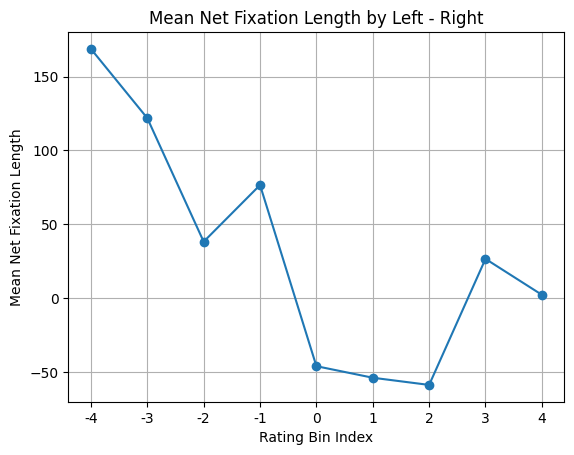

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy example: replace with your actual all_fixations data
# all_fixations = [(net_fixation, rating), ...]
# For demo purposes only
# all_fixations = [(1.2, 0), (2.4, 1), ...]  ← this should be pre-defined

# Define rating bins
rating_bins = [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5]  # edges of bins

# Convert to numpy arrays
numbers = np.array([x[0] for x in all_fixations])
ratings = np.array([x[1] for x in all_fixations])

# Prepare data for plotting
x_positions = []  # 0, 1, 2, ...
means = []

# Loop through each bin
for i in range(len(rating_bins) - 1):
    bin_start = rating_bins[i]
    bin_end = rating_bins[i + 1]

    mask = (ratings >= bin_start) & (ratings < bin_end)
    bin_data = numbers[mask]

    x_positions.append(i)  # always include the bin

    if len(bin_data) > 0:
        mean = np.mean(bin_data)
    else:
        mean = 0

    means.append(mean)

# Plotting the data
plt.plot(x_positions, means, marker='o')  # <-- This line plots the data

plt.xlabel('Rating Bin Index')
plt.ylabel('Mean Net Fixation Length')
plt.title('Mean Net Fixation Length by Left - Right')
plt.xticks(
    ticks=x_positions,
    labels=[f'{rating_bins[i]}' for i in x_positions]
)
plt.grid(True)
plt.show()

## Choice by rating

In [18]:
import pandas as pd
import ast

df = pd.read_csv('/Users/braydenchien/Desktop/Enkavilab/DDM/simulated_data/sim_trials_42_0.75_0.38_0.35.csv')
df['fixation'] = df['fixation'].apply(ast.literal_eval)

/var/folders/59/03h51wmn6xn1jhvb7kj9fjc40000gn/T/ipykernel_15706/3556667227.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_left_by_bin = df.groupby("rdv_bin")["choice"].apply(lambda x: (x == 0).mean())
/var/folders/59/03h51wmn6xn1jhvb7kj9fjc40000gn/T/ipykernel_15706/3556667227.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("rdv_bin")["rdv"].mean()


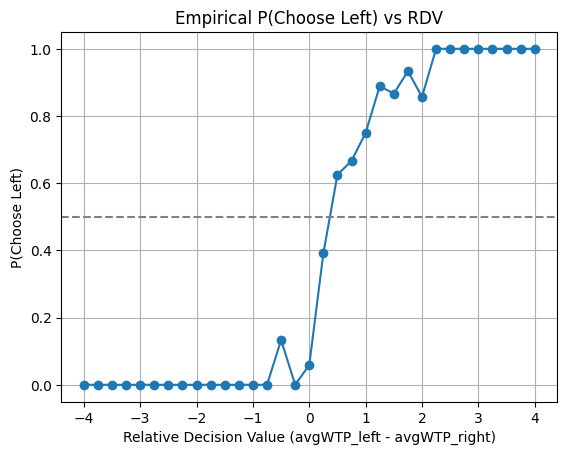

In [19]:
import matplotlib.pyplot as plt

# Compute RDV
df["rdv"] = df["avgWTP_left"] - df["avgWTP_right"]

# Group trials by binned RDV values
num_bins = 33  # you can change this
df["rdv_bin"] = pd.cut(df["rdv"], bins=num_bins)

# Calculate probability of choosing left (choice == 0) for each RDV bin
prob_left_by_bin = df.groupby("rdv_bin")["choice"].apply(lambda x: (x == 0).mean())

# Compute bin centers for plotting
bin_centers = df.groupby("rdv_bin")["rdv"].mean()

# Plot
plt.plot(bin_centers, prob_left_by_bin, marker='o', linestyle='-')
plt.axhline(0.5, color='gray', linestyle='--')
plt.xlabel("Relative Decision Value (avgWTP_left - avgWTP_right)")
plt.ylabel("P(Choose Left)")
plt.title("Empirical P(Choose Left) vs RDV")
plt.grid(True)
plt.show()


In [20]:
bin_counts = df["rdv_bin"].value_counts().sort_index()
print(bin_counts)

rdv_bin
(-4.008, -3.758]    17
(-3.758, -3.515]    18
(-3.515, -3.273]    17
(-3.273, -3.03]     21
(-3.03, -2.788]     18
(-2.788, -2.545]    23
(-2.545, -2.303]    17
(-2.303, -2.061]    15
(-2.061, -1.818]    17
(-1.818, -1.576]     8
(-1.576, -1.333]    10
(-1.333, -1.091]    15
(-1.091, -0.848]    17
(-0.848, -0.606]    15
(-0.606, -0.364]    15
(-0.364, -0.121]    16
(-0.121, 0.121]     17
(0.121, 0.364]      23
(0.364, 0.606]      16
(0.606, 0.848]      12
(0.848, 1.091]      16
(1.091, 1.333]       9
(1.333, 1.576]      15
(1.576, 1.818]      15
(1.818, 2.061]       7
(2.061, 2.303]      14
(2.303, 2.545]      16
(2.545, 2.788]      13
(2.788, 3.03]       16
(3.03, 3.273]       14
(3.273, 3.515]       9
(3.515, 3.758]      16
(3.758, 4.0]        13
Name: count, dtype: int64
